# Script for generating Synthetic, Biological Raman Spectrscopy
This notebook contains functions and parameters for creating Synthetic Raman Spectroscopy datasets for testing the efficacy
of SpecReX as a Spectral Explainability Tool.

We generate 3 different datasets, namely,
1. Single Peak (Only a single peak is a discriminating factors)
2. Double Peak (Two of the three peaks are discriminating factors)
3. Complex Peak (Single discriminating factor, however the signal is much more complex)

In [1]:
import os
import copy
import numpy as np
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.gridspec import GridSpec
from scipy.interpolate import CubicSpline
from sklearn.model_selection import train_test_split

In [2]:
# Truncate spectrum function
def truncate_spectrum(wn, spectra, trunc_region=5, wavenumber_shift=5):
    trunc_spectrum = np.copy(spectra)
    trunc_wn = np.copy(wn)

    if wavenumber_shift != 0:
        trunc_spectrum = np.roll(spectra, wavenumber_shift)

    trunc_spectrum = trunc_spectrum[trunc_region:-trunc_region]
    trunc_wn = wn[trunc_region:-trunc_region]

    return trunc_spectrum, trunc_wn

# Function to generate a biased random integer for wavenumber shifting
def biased_random_int(shifting_factor = 24):
    return int(np.random.triangular(-shifting_factor, 0, shifting_factor))

#Generate combinations of peaks
def generate_combinations(lst):
    all_combinations = []
    if len(lst) > 1:
        for c in range(1, len(lst)):
            all_combinations.extend(combinations(lst,c))
    else:
        all_combinations.append([0])
    
    return [list(comb) for comb in all_combinations]

In [3]:
def generate_spectrum(peaks_positions=[200, 750], peaks_widths=[10, 15],
                      peaks_heights=[4000, 2000, 3000],num_baseline_points=5, 
                      noise_level=50,baseline_cap = 2000,
                      spectrum_length=900, wavenumber_shift = False, shifting_factor = 24):
    """
    Generates a simulated spectrum with given peak parameters, a number of random baseline points, noise level,
    and adjusts for non-negativity. Applies SNV normalization before returning the spectrum.

    The examples created fixes the positions of the actual peaks, but significantly varies the position of the
    red herring peaks, also creates examples where a missing peak is present, but is returned as a different class.

    We shall have examples where both peaks are missing from time to time.

    Parameters:
    - peaks_positions: List of positions for the peaks.
    - peaks_widths: List of widths for the peaks.
    - peaks_heights: List of heights for the peaks.
    - num_baseline_points: Number of baseline points to generate.
    - noise_level: The standard deviation of the normally distributed noise.
    - baseline_cap: Maximum value for baseline points.
    - spectrum_length: The length of the simulated spectrum.

    Returns:
    - snv_normalized_spectrum: The SNV normalized simulated spectrum as a numpy array.
    """

    if num_baseline_points <= 1:
        raise ValueError("num_baseline_points must be greater than 1 to perform spline interpolation.")   
    
    x_values = np.linspace(0, spectrum_length, spectrum_length)
    peaks = np.zeros_like(x_values)

    for position, width, height in zip(peaks_positions, peaks_widths, peaks_heights):

    # Calculate the scaling factor. Since norm.pdf(x, loc, scale) at x=loc is 1/(sqrt(2*pi)*scale),
    # to get the actual height to match `height`, we multiply by `height` / (1/(sqrt(2*pi)*width)).
      scaling_factor = height / (1 / (np.sqrt(2 * np.pi) * width))
    # Apply the scaling factor to the Gaussian function
      peaks += scaling_factor * norm.pdf(x_values, position, width)

    # Generate noise
    noise = noise_level * np.random.normal(size=x_values.shape)

    #baseline_cap = np.mean(peaks_heights)
    baseline_x = np.linspace(0, max(x_values), num_baseline_points)
    bias_factor = np.linspace(baseline_cap, 0, num_baseline_points)
    baseline_y = np.random.rand(num_baseline_points) * bias_factor

    cs = CubicSpline(baseline_x, baseline_y)
    baseline = cs(x_values)

    simulated_spectrum_spline = peaks + baseline + noise

    # Apply wavenumber shift
    if wavenumber_shift:
      wn_shift = biased_random_int()
      simulated_spectrum_spline,_ = truncate_spectrum(x_values, simulated_spectrum_spline, trunc_region=shifting_factor, wavenumber_shift=wn_shift)

    # Apply SNV normalization
    mean_val = np.mean(simulated_spectrum_spline)
    std_dev = np.std(simulated_spectrum_spline)
    snv_normalized_spectrum = (simulated_spectrum_spline - mean_val) / std_dev

    return snv_normalized_spectrum

In [4]:
# Function to generate the dataset
def generate_dataset(num_samples_per_class=1000,
                    params_class_0 = {"num_baseline_points": 5,
                                    "peaks_positions": [250, 700],
                                    "peaks_widths": [10, 15],
                                    "peaks_heights": [4000, 3000],
                                    "fixed_peaks_positions": [],
                                    "fixed_peaks_heights": [],
                                    "fixed_peaks_widths": [],
                                    "noise_level": 150,
                                    "wavenumber_shift": True,
                                    "num_faux_peaks": 1,},
                    params_class_1 = {"num_baseline_points": 5,
                                    "peaks_positions": [150, 750],
                                    "peaks_widths": [10, 15],
                                    "peaks_heights": [4000, 3000],
                                    "fixed_peaks_positions": [],
                                    "fixed_peaks_heights": [],
                                    "fixed_peaks_widths": [],
                                    "noise_level": 150,
                                    "wavenumber_shift": True,
                                    "num_faux_peaks": 1,},
                    dist_btwn_peaks = 100,
                    wn_length = 852,
                    seed = 42,
                    *args):
    #Set seed
    np.random.seed(seed)     

    #Generate a random value from 0-2 (Ratio will be set when generating random numbers)
    # 0 - A subset of peaks are present
    # 1 - All peaks are present (The only correct class)
    # 2- All peaks are not present


    wn_length = wn_length  # Example wavenumber length
    spectras = []
    labels = []

    #Create single iterator for all classes that we want
    all_classes = [params_class_0, params_class_1] + list(args)

    #Number of faux examples per class
    faux_examples_per_class = int(num_samples_per_class/len(all_classes))
    
    # Generate data for class 0 and class 1
    for class_index, params in tqdm(enumerate(all_classes)):
        class_count = 0
        faux_class_count = 0
        peak_combs = generate_combinations(list(range(len(params['peaks_positions']))))
        num_faux_peaks = params['num_faux_peaks']
        while class_count < num_samples_per_class or faux_class_count < faux_examples_per_class:
            if faux_class_count == faux_examples_per_class:
                spectra_type = np.random.choice([0,1,2], p = [0,1,0])
            elif class_count == num_samples_per_class:
                spectra_type = np.random.choice([0,1,2], p = [0.5,0,0.5])
            else:
                spectra_type = np.random.choice([0,1,2], p = [0.15,0.7,0.15])

            if spectra_type == 0:
                idxs = peak_combs[np.random.randint(0,len(peak_combs))]
                peak_heights = [params['peaks_heights'][idx] for idx in idxs]
                peak_widths = [params['peaks_widths'][idx] for idx in idxs]
                peak_positions = [params['peaks_positions'][idx] for idx in idxs]
                faux_class_count += 1
        
            elif spectra_type == 1:
                peak_heights = params['peaks_heights']
                peak_widths = params['peaks_widths']
                peak_positions = params['peaks_positions']
                class_count += 1

            elif spectra_type == 2:
                peak_heights = []
                peak_widths = []
                peak_positions = []
                faux_class_count += 1

            #Add the fixed peaks
            peak_heights = peak_heights + params['fixed_peaks_heights']
            peak_widths = peak_widths + params['fixed_peaks_widths']
            peak_positions = peak_positions + params['fixed_peaks_positions']
            

            ideal_pos = False
            while not ideal_pos:
                for _ in range(num_faux_peaks):
                    #Create peak position randomly for faux peak
                    faux_peak_position = np.random.choice(np.arange(100, wn_length-100))               
                    
                    #Make sure peak is atleast 100 apart from the other peaks
                    if len(peak_positions) == 0:
                        ideal_pos = True
                    else:
                        ideal_pos = True
                        for pos in peak_positions:
                            if pos >= faux_peak_position - dist_btwn_peaks and pos <= faux_peak_position + dist_btwn_peaks:
                                ideal_pos = False                    

                    if ideal_pos == True:
                        #Generate faux peak widths and heights
                        faux_peak_width = np.random.randint(low=10,high=20)
                        faux_peak_height = np.random.randint(low=3,high = 5) * 1000

                        #Append to the respective arrays
                        peak_positions.append(faux_peak_position)
                        peak_heights.append(faux_peak_height)
                        peak_widths.append(faux_peak_width)
            
            spectra = generate_spectrum(peaks_positions=peak_positions,
                                        peaks_widths=peak_widths,
                                        peaks_heights=peak_heights,
                                        wavenumber_shift=True)
            
            label = class_index if spectra_type == 1 else 2

            #Append spectra and label to the respective arrays
            spectras.append(spectra.reshape(1,-1))
            labels.append(label)

    #Create a single numpy array from the arrays of spectra
    spectras = np.concatenate(spectras,axis = 0)
    labels = np.array(labels)

    return spectras, labels

In [5]:
def visualise_dataset(spectra, labels):
    # Define colors for each class for clarity
    colors = ['aqua', 'darkviolet', 'olive']
    
    # Assuming 'spectra' and 'labels' are already generated and contain your simulated data
    num_classes = len(np.unique(labels))  # Determine the number of classes
    
    # Create the figure and grid spec based on the number of classes
    fig = plt.figure(figsize=(12, 7 + (num_classes - 3)))  # Adjust height for additional rows
    gs = GridSpec(nrows=num_classes, ncols=3)
    
    # Main plot for mean spectra
    main_ax = fig.add_subplot(gs[:, 0:2])
    
    for class_index in range(num_classes):
        class_spectra = spectra[labels == class_index]
        mean = np.mean(class_spectra, axis=0)
        std = np.std(class_spectra, axis=0)
        wavenumbers = np.arange(len(mean))
    
        # Plotting the mean on the main plot
        main_ax.plot(wavenumbers, mean, label=f'Class {class_index} Mean', color=colors[class_index % len(colors)])
    
        # Creating smaller std plots for each class
        ax = fig.add_subplot(gs[class_index, 2])
        ax.plot(wavenumbers, mean, color=colors[class_index % len(colors)])
        ax.fill_between(wavenumbers, mean-std, mean+std, alpha=0.25, color=colors[class_index % len(colors)])
        ax.set_xticks([])
        ax.set_yticks([])
        if class_index == num_classes - 1:  # Add x-label on the bottom std plot
            ax.set_xlabel('Wavenumber Shift (cm$^{-1}$)')
    
    # Finalizing the main plot
    main_ax.legend(loc='upper right', prop={'size': 12})
    main_ax.set_ylabel('Intensity (A.U.)')
    main_ax.set_xlabel('Wavenumber Shift (cm$^{-1}$)')
    
    plt.tight_layout()
    plt.show()

In [13]:
def store_dataset(spectra, labels, path,
                 split = [0.8,0.1,0.1], seed = 42,
                 shape = (1,852)):
    
    #Create train-val-test split
    X_train, X_val, y_train, y_val = train_test_split(spectra, labels, test_size = 1 - split[0], random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = split[1]/sum(split[1:]), random_state=seed)

    for dset in [('Train', X_train, y_train), ('Val', X_val, y_val), ('Test', X_test, y_test)]:
        #Check if the directory exists
        save_dir = os.path.join(path,dset[0])
        
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
                
        for idx in tqdm(range(len(dset[1]))):
            assert dset[1][idx].reshape(1,-1).shape == shape
            class_id = dset[2][idx]
            np.save(os.path.join(save_dir,f"train{idx+1}_class{class_id}.npy"),dset[1][idx].reshape(1,-1))

## Single Peak

In [18]:
class_0_params = {
        "num_baseline_points": 5,
        "peaks_positions": [250],
        "peaks_widths": [4],
        "peaks_heights": [4000],
        "fixed_peaks_positions": [],
        "fixed_peaks_heights": [],
        "fixed_peaks_widths": [],
        "noise_level": 150,
        "wavenumber_shift": True,
        "num_faux_peaks": 1,
}

class_1_params = {
    "num_baseline_points": 5,
    "peaks_positions": [750],
    "peaks_widths": [4],
    "peaks_heights": [4000],
    "fixed_peaks_positions": [],
    "fixed_peaks_heights": [],
    "fixed_peaks_widths": [],
    "noise_level": 150,
    "wavenumber_shift": True,
    "num_faux_peaks": 1,
}

spectra, labels = generate_dataset(num_samples_per_class=5000, params_class_0=class_0_params,
                                   params_class_1=class_1_params, dist_btwn_peaks=100)

2it [00:05,  2.94s/it]


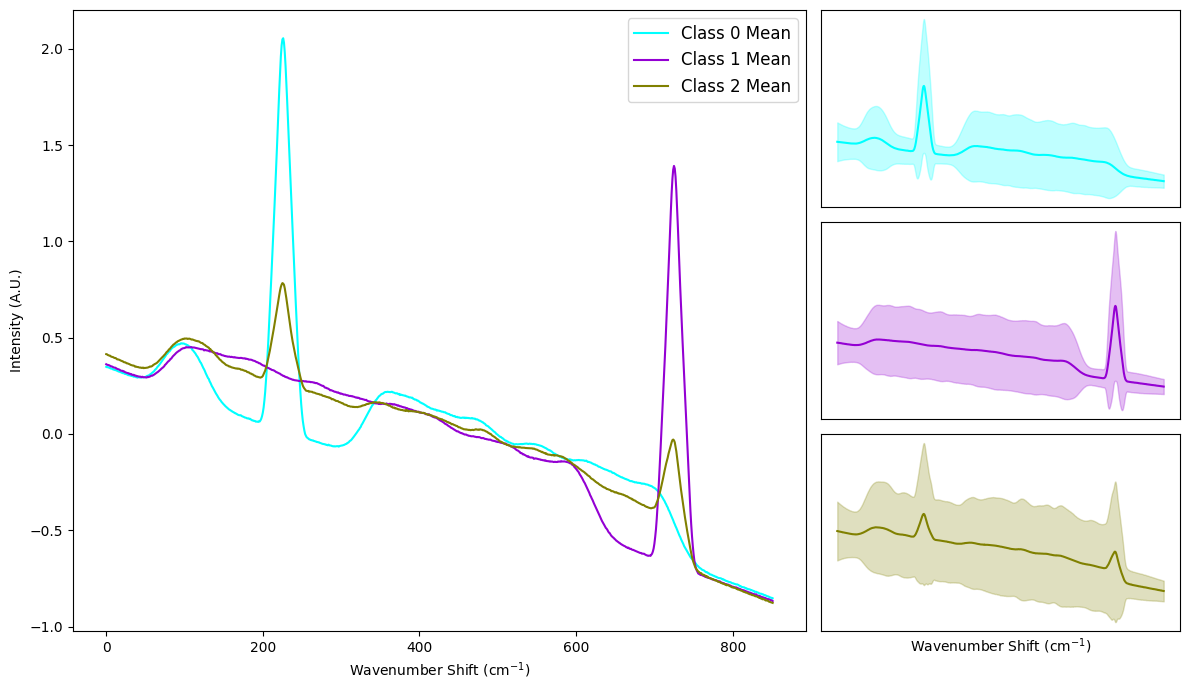

In [19]:
visualise_dataset(spectra,labels)

In [20]:
#Store the dataset
single_peak_dir = 'Simulated Dataset/Single Peak'
store_dataset(spectra=spectra, labels=labels, path = single_peak_dir)

100%|██████████| 1500/1500 [00:00<00:00, 10914.82it/s]


## Double Peak

In [21]:
class_0_params = {
        "num_baseline_points": 5,
        "peaks_positions": [250, 700],
        "peaks_widths": [10, 15],
        "peaks_heights": [4000, 3000],
        "fixed_peaks_positions": [],
        "fixed_peaks_heights": [],
        "fixed_peaks_widths": [],
        "noise_level": 150,
        "wavenumber_shift": True,
        "num_faux_peaks": 1,
    }

    # Class 1 Parameters
class_1_params = {
        "num_baseline_points": 5,
        "peaks_positions": [150, 750],
        "peaks_widths": [10, 15],
        "peaks_heights": [4000, 3000],
        "fixed_peaks_positions": [],
        "fixed_peaks_heights": [],
        "fixed_peaks_widths": [],
        "noise_level": 150,
        "wavenumber_shift": True,
        "num_faux_peaks": 1,
    }

spectra, labels = generate_dataset(num_samples_per_class=5000, params_class_0=class_0_params,
                                   params_class_1=class_1_params, dist_btwn_peaks=100)

2it [00:06,  3.24s/it]


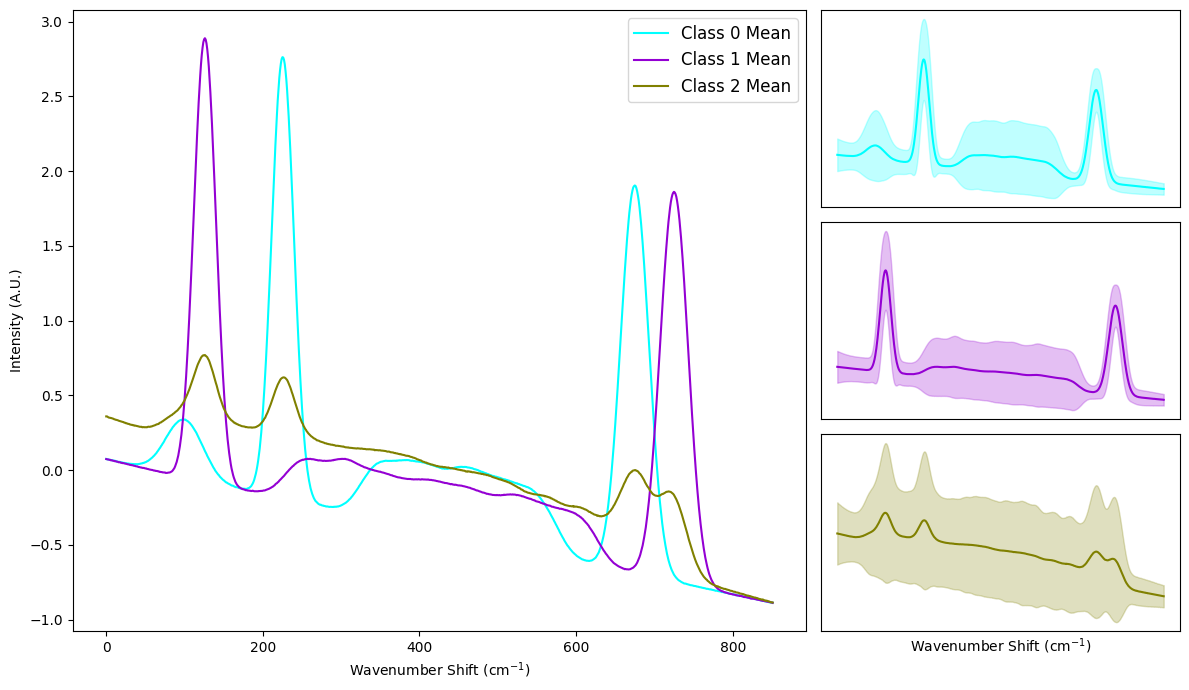

In [22]:
visualise_dataset(spectra,labels)

In [23]:
#Store the dataset
double_peak_dir = 'Simulated Dataset/Double Peak'
store_dataset(spectra=spectra, labels=labels, path = double_peak_dir)

100%|██████████| 1500/1500 [00:00<00:00, 8752.22it/s]


## Complex Peak

In [24]:
# Class 0 Parameters
class_0_params = {
    "num_baseline_points": 5,
    "peaks_positions": [100, 800, 1400, 700, 1002, 1400, 1390, 1410, 1500, 1750, 550, 530, 200, 250, 335, 410, 1020, 370],
    "peaks_widths": [200, 75, 250, 10, 2, 30, 4, 3, 3, 8, 4, 4, 6, 6, 5, 7, 5, 5],
    "peaks_heights": [10000, 5000, 5000, 5500, 7000, 4000, 700, 650, 500, 800, 800, 750, 300, 400, 300, 400, 500, 1600],
    "baseline_cap": 3000,
    "fixed_peaks_positions": [],
    "fixed_peaks_heights": [],
    "fixed_peaks_widths": [],
    "noise_level": 100,
    "spectrum_length": 1800,
    "wavenumber_shift": True,
    "num_faux_peaks": 1,
}

# Class 1 Parameters
class_1_params = {
    "num_baseline_points": 5,
    "peaks_positions": [100, 800, 1400, 700, 1002, 1400, 1390, 1410, 1500, 1750, 550, 530, 200, 250, 335, 410, 1020, 1100],
    "peaks_widths": [200, 75, 250, 10, 2, 30, 4, 3, 3, 8, 4, 4, 6, 6, 5, 7, 5, 10],
    "peaks_heights": [10000, 5000, 5000, 5500, 7000, 4000, 700, 650, 500, 800, 800, 750, 300, 400, 300, 400, 500, 1200],
    "baseline_cap": 3000,
    "fixed_peaks_positions": [],
    "fixed_peaks_heights": [],
    "fixed_peaks_widths": [],
    "noise_level": 100,
    "spectrum_length": 1800,
    "wavenumber_shift": True,
    "num_faux_peaks": 1,
}

spectra, labels = generate_dataset(num_samples_per_class=5000, params_class_0=class_0_params,
                                   params_class_1=class_1_params, dist_btwn_peaks=100, wn_length=1752)

2it [00:17,  8.55s/it]


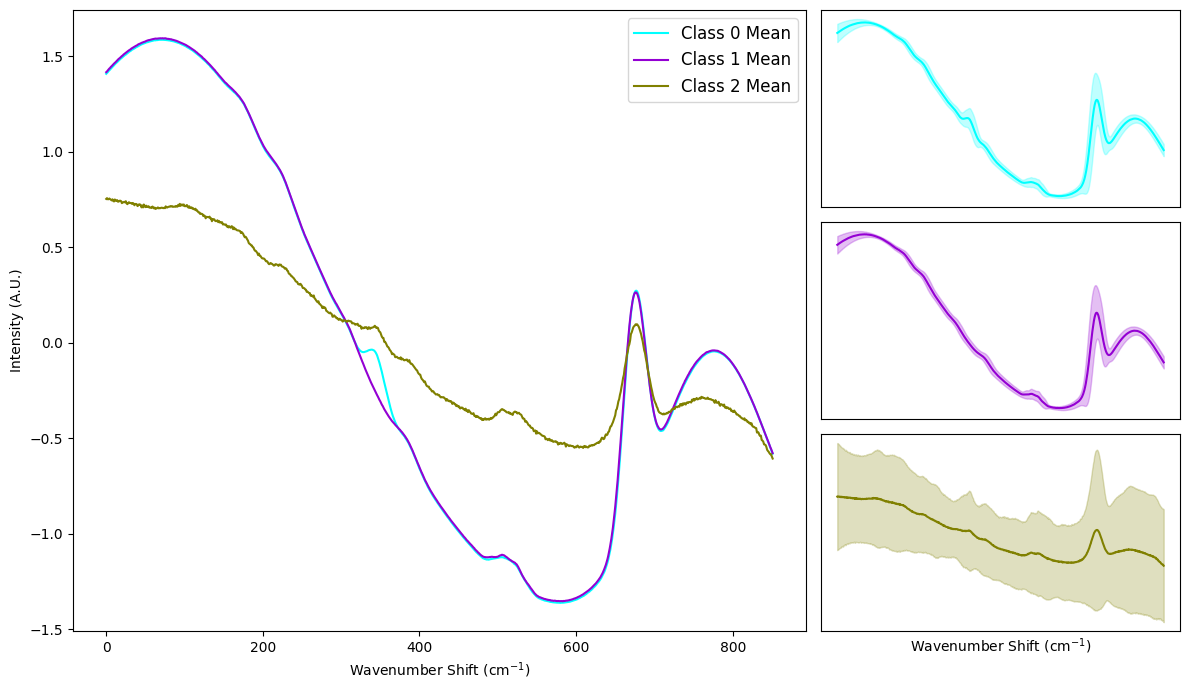

In [81]:
visualise_dataset(spectra,labels)

In [ ]:
#Store the dataset
complex_peak_dir = 'Simulated Dataset/Complex Peak'
store_dataset(spectra=spectra, labels=labels, path = complex_peak_dir)